In [2]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
import re

import operator
import string

from sklearn.metrics import mean_squared_error, roc_auc_score
from math import sqrt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import imblearn
from imblearn.over_sampling import SMOTE, RandomOverSampler

from mlxtend.feature_selection import SequentialFeatureSelector as SFS


In [3]:
data = pd.read_csv('/kaggle/input/online-edu/Online class teaching learning impact dataset1.csv', encoding='latin-1')

This dataset offers insights into student perception of MOOC study process during the Covid-19 pandemic. It illustrates the background, study needs and expectations of the students. Here it will be used to select and train a ML model that can reliably predict whether a student will have a helpful suggestion after completing the course, based on the influencing factors outlined in the queestionnaire.

In [4]:
#original questions & column names:

0. Timestamp                                                                                                                      358 non-null    object
1. What is your gender?                                                                                                        358 non-null    object
2. What is your age?                                                                                                           358 non-null    object
3. What is your residential area?                                                                                              358 non-null    object
4. Select the Degree while undergone online teaching?                                                                          358 non-null    object
5. What is your Major?                                                                                                         358 non-null    object
6. What is the monthly income of your family?                                                                                  358 non-null    object
7. Choose the gadget do you use to attend online classes?                                                                      358 non-null    object
8. The gadget you use to attend online classes is ?	                                                                         358 non-null    object
9. What is the most used platform for online learning?                                                                         358 non-null    object
10. What is the most used platform for Student's Assessment / Evaluation?                                                      358 non-null    object
11. What are the difficulties you encounter during the Online classes?                                                         358 non-null    object
12. What are the sources of internet?                                                                                          358 non-null    object
13. How do you attend your Online classes?                                                                                     358 non-null    object
14. How often do you want the professor to conduct the classes?                                                                358 non-null    object
15. Suitable duration for online classes (per class)?                                                                          358 non-null    object
16. How much time do you need as break between two online classes?                                                             358 non-null    object
17. Do you think that if your family income lowered after Second Waves of COVID-19, this would affect your education?          358 non-null    object
18. Pandemic may cause you to discontinue your Education?                                                                      358 non-null    object
19. Have you ever attended any online classes before the pandemic (describe your IT skills)                                    358 non-null    object
20. Are you vaccinated?                                                                                                        358 non-null    object
21. Give your understanding level during Online practical /Lab along with Regular Classes?                                     358 non-null    object
22. Do you feel any variation on your health after second waves?                                                               358 non-null    object
23. What are the advantages of E-learning?                                                                                     358 non-null    object
24. Choose the dislikes of E-learning?                                                                                         358 non-null    object
25. The use of the Online Lab/practical made me more confident about my ability to successfully complete the Lab experiments?  358 non-null    object
26. The availability of software(s) teaching in online practical classes are                                                   358 non-null    object
27. Any Suggestions, for improving Online Education System in India?                                                           358 non-null    object

In [5]:
#column rename:

data.columns.values[0:28] = ['timestamp', 'gender', 'age', 'residential_area', 'degree_online', 'major', 'fam_inc_monthly', 'gadget', 'gadget_owner', 'platf_learning', 'platf_eval', 'difficulties', 'internet_sources', 'attend', 'class_freq', 'duration', 'break', 'fam_inc_infl', 'discontinue', 'att_before', 'vaccinated', 'understanding_lvl', 'var_second', 'adv_elearn', 'dislikes', 'confidence', 'soft_availability', 'suggestions']
data.head()

,timestamp,gender,age,residential_area,degree_online,major,fam_inc_monthly,gadget,gadget_owner,platf_learning,...,discontinue,att_before,vaccinated,understanding_lvl,var_second,adv_elearn,dislikes,confidence,soft_availability,suggestions
0,11/8/2022 12:12,Male,18  25,Town,Master,Digital electronics,">5000 to <=10,000",Smartphone,My Own,Google Meet,...,Yes,High,Not applicable(<18 age),Highly effective,Yes,Easy Access of online materials,No Patient Listening,Neutral,Easily available,Nothing
1,11/8/2022 12:13,Female,18  25,Municipality,PhD Scholar,Computer sciece,">10,000 to <=20,000",Smartphone,Family members,Google Meet,...,No,Not attended,Not applicable(<18 age),Not interactive,No,Classes Interactivity,No Patient Listening,Agree,Easily available,No
2,11/8/2022 12:14,Male,18  25,Village,Bachelor,Computer application,<=5000,Smartphone,Family members,Google Meet,...,No,Not attended,1st Dose,Highly effective,No,Learning on your own pace,Bad Learning condition at My Home,Agree,Easily available,No
3,11/8/2022 12:14,Male,18  25,Metro-city,Bachelor,Computer Application,">5000 to <=10,000",Smartphone,My Own,Google Meet,...,No,Not attended,Not applicable(<18 age),Not interactive,No,Ability of stay-at-home,Network and Technical Problems faced,Disagree,Not interested in Online practical,No
4,11/8/2022 12:15,Male,18  25,Town,Bca,Commerce,">5000 to <=10,000",Smartphone,My Own,Google Meet,...,No,Low,1st Dose,Not interactive,Yes,Easy Access of online materials,Network and Technical Problems faced,Agree,Easily available,Yes free network all students facilities


In [6]:
# age has the same values everywhere -> redundant
# other currently unnecessary columns include 'timestamp' and 'suggestions'. The latter can eventually be used for nlp tasks, but we'll keep it here until the language data is normalized
data.drop(columns=['timestamp', 'age'], axis=1, inplace=True)

In [7]:
#what we have:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358 entries, 0 to 357
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   gender             358 non-null    object
 1   residential_area   358 non-null    object
 2   degree_online      358 non-null    object
 3   major              358 non-null    object
 4   fam_inc_monthly    358 non-null    object
 5   gadget             358 non-null    object
 6   gadget_owner       358 non-null    object
 7   platf_learning     358 non-null    object
 8   platf_eval         358 non-null    object
 9   difficulties       358 non-null    object
 10  internet_sources   358 non-null    object
 11  attend             358 non-null    object
 12  class_freq         358 non-null    object
 13  duration           358 non-null    object
 14  break              358 non-null    object
 15  fam_inc_infl       358 non-null    object
 16  discontinue        358 non-null    object
 1

In [8]:
#cleaning up the data

#degrees
#BCA can join Bachelor, same for Btech, others can be aggregated into 'some degree, since specs are reflected in majors'
data['degree_online'] = data['degree_online'].replace('Bca', 'Bachelor').replace('Btech', 'Bachelor').replace('EEE', 'Degree').replace('Engineering', 'Degree').replace('Arts and sciences', 'Degree')
Counter(data.degree_online).values()
degrees = list(Counter(data.degree_online).values())
label = list(Counter(data.degree_online).keys())

#majors
data['major'] = data['major'].apply(lambda x: x.strip().lower())
data['major'] = data['major'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
data['major'] = data['major'].apply(lambda x: re.sub(r'com*pute[r|t]', 'computer', x))
data['major'] = data['major'].apply(lambda x: re.sub(r'sc\w*', 'science', x))
data['major'] = data['major'].apply(lambda x: re.sub(r'computer application\w*', 'computer application', x))
data['major'] = data['major'].apply(lambda x: re.sub(r'\w+\s*computer science\s+\w+', 'computer science', x))
data['major'] = data['major'].apply(lambda x: re.sub(r'm[\s]*science', '', x))
comp_science = ['g pushparaj computer science', 'computer science hi', 'bscience science', 'aathi kesavan mathematics']
data['major'] = data['major'].replace(comp_science, 'computer science')

data['major'] = data['major'].replace('maths', 'mathematics')

#reducing to first majors
comp_majors = ['computer science  chemistry', 'computer science and engineering', 'computer science  mathematics']
data['major'] = data['major'].replace(comp_majors, 'computer science')
data['major'] = data['major'].replace('networking and information security', 'network and information security')
appl_majors = ['master of computer application', 'bca']
data['major'] = data['major'].replace(appl_majors, 'computer application')
com_majors = ['commence', 'commerce with computer application']
data['major'] = data['major'].replace(com_majors, 'commerce')
data['major'] = data['major'].apply(lambda x: x.strip())
Counter(data.major) 

#var_second
data.var_second.unique() #unify -> described cases have nothing to do with the virus
reasons = ['Currently i have typhoid fever  reason : climate change ', 'Having eye problems, headache, neck and back pain due to sitting in front of laptop all day', "I feel very depressed because of those online classes that i can't understand. ", 'I got SLE when the pandemic started. But it has nothing to do with the virus. ']
data['var_second'] = data['var_second'].replace(reasons, 'No')

#turning breaks into integer values
data['break'].value_counts()
data['break'] = data['break'].apply(lambda x: re.sub(r'No', '0', x))
data['break'] = data['break'].replace('Don\'t want online classes', '0')
data['break'] = data['break'].replace('1 hour', '60')
data['break'] = data['break'].replace('3 hours', '180')
data['break'] = data['break'].apply(lambda x: re.sub(r'\D', '', x))
data['break'] = data['break'].astype('int64')
data['break'].value_counts()

#soft_availability
data['soft_availability'] = data['soft_availability'].apply(lambda x: re.sub(r'.*p.?racticals?\s?.*', r'No practical', x))
data['soft_availability'] = data['soft_availability'].replace('Not interested ', 'Not interested in Online practical')
data['soft_availability'] = data['soft_availability'].replace('My major is mathematics so l don\'t have any practical', 'No practical')
data['soft_availability'] = data['soft_availability'].replace('Our staffs are not taking online practical classes', 'No practical')
data['soft_availability'] = data['soft_availability'].str.strip()
Counter(data.soft_availability) 

#simplifying the suggestions -> 0 if there is none or nothing, 1 if there is -> labels
#later -> sentiment analysis
data['suggestions'] = data['suggestions'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
data['suggestions'] = data['suggestions'].apply(lambda x: x.lower())
data['suggestions'] = data['suggestions'].str.strip()
suggested = ['no suggestions', 'no suggestion', 'not suggestions', 'i dont have suggestion right now', 'noi dont have any suggestions', 'dont know', 'nothing', '', 'if', 's', 'no idea', 'i have no idea', 'noo', 'nono', 'nil', 'nill', 'nope', 'none', 'i dont know', 'nothing to say', 'no quarries', 'nk', 'i dont have one', 'non', ]
data['suggestions'] = data['suggestions'].replace(suggested, 'no')

data['suggestions_ml'] = data['suggestions'].apply(lambda i: i == '0' if (i == 'no') else '1')
data['suggestions_ml'] = data['suggestions_ml'].replace(False, '0')
data['suggestions_ml'] = data['suggestions_ml'].astype('int64')

# Data transformation for machine learning

In [9]:
#gender
data['gender_ml'] = data.gender.map({'Male': 0, 'Female': 1, 'Transgender': 2})
#residence
data['residence_ml'] = data.residential_area.map({'Town': 0, 'Village': 1, 'Municipality': 2, 'Metro-city': 3, 'Very Remote Area': 4})
#degree
data['degree_ml'] = data.degree_online.map({'Bachelor': 0, 'Master': 1, 'Degree': 2, 'PhD Scholar': 3, 'Diploma': 4, '10 std': 5})
#major
data['major'] = data['major'].astype('category')
data['major_ml'] = data['major'].cat.codes
#family income per month
data['fam_inc_monthly_ml'] = data.fam_inc_monthly.map({'>5000 to <=10,000': 0, '>10,000 to <=20,000': 1, '>20,000 to <=30,000': 2, '<=5000': 3, 'Above 50,000': 4, '>30,000 to <=40,000': 5})
#gadget
data['gadget_ml'] = data['gadget'].map({'Smartphone': 0, 'Laptop': 1, 'Desktop': 2, 'Smartphone, Desktop': 3, 'Smartphone, Laptop': 4})
#gadget_owner
data['gadget_owner_ml'] = data['gadget_owner'].map({'My Own': 0, 'Family members': 1, 'No Device Owned': 2, 'Hired': 3})
#platf_learning
data['platf_learning_ml'] = data['platf_learning'].map({'Google Meet': 0, 'Zoom': 1, 'YouTube': 2, 'Microsoft Teams': 3, 'Skype': 4, 'No': 5})
#platf_eval
data['platf_eval_ml'] = data['platf_eval'].map({'Google Classroom': 0, 'Whatsapp': 1, 'E-mail': 2, 'Google Forms': 3, 'Moodle': 4, 'All': 5, 'Edmodo': 6, 'No': 7})
#difficulties
data['difficulties'] = data['difficulties'].astype('category')
data['difficulties_ml'] = data['difficulties'].cat.codes
#internet_sources
data['internet_sources_ml'] = data['internet_sources'].map({'Mobile data pack': 0, 'Mobile data pack, Wi-Fi': 1, 'Wi-Fi': 2, 'LAN, Mobile data pack, Wi-Fi': 3, 'LAN, Mobile data pack': 4, 'LAN': 5, 'LAN, Wi-Fi': 6})
#attended
data['attend_ml'] = data['attend'].map({'Live online Classes': 0, 'Recorded Live classes': 1, 'Textbooks or Materials Issued': 2, 'Website/YouTube/any other application': 3, 'Recorded classes  uploaded on College/University website': 4})
#class_freq
data['class_freq_ml'] = data['class_freq'].map({'Daily (Half-a-day)': 0, 'Daily (FN & AN)': 1, 'Weekly 2 or 3 days': 2, 'Weekly once': 3, 'Based on their mood': 4, 'Don\'t want online classes': 5, 'Iwant only offline classes': 6, 'Weekly 5 days only ': 7})
#duration
data['duration_ml'] = data['duration'].map({'30-45 min': 0, '45-50 min': 1, '1 Hour': 2, '50-55 min': 3})
#break
data['break_ml'] = data['break']
#fam_inc_infl
data['fam_inc_infl_ml'] = data['fam_inc_infl'].map({'No': 0, 'Yes': 1})
#discontinue
data['discontinue_ml'] = data['discontinue'].map({'No': 0, 'Yes': 1})
#att_before
data['att_before_ml'] = data['att_before'].map({'Not attended': 0, 'Low': 1, 'Medium': 2, 'High': 3})
#vaccinated
data['vaccinated_ml'] = data['vaccinated'].map({'No belief': 0, 'Not vaccinated (Health issue)': 0, 'Not applicable(<18 age)': 0, '1st Dose': 1, '2nd Dose': 2})
#understanding_lvl
data['understanding_lvl_ml'] = data['understanding_lvl'].map({'Cannot practice ourself': 0, 'Not interactive': 1, 'Highly effective': 2, 'Very Poor': 3})
#var_second
data['var_second_ml'] = data['var_second'].map({'No': 0, 'Yes': 1})
#adv_elearn
data['adv_elearn'] = data['adv_elearn'].astype('category')
data['adv_elearn_ml'] = data['adv_elearn'].cat.codes
#dislikes
data['dislikes'] = data['dislikes'].astype('category')
data['dislikes_ml'] = data['dislikes'].cat.codes
# confidence
data['confidence_ml'] = data['confidence'].map({'Neutral': 0, 'Disagree': 1, 'Agree': 2, 'Strongly disagree': 3, 'Strongly agree': 4})
#soft_availability
data['soft_availability_ml'] = data['soft_availability'].map({'No practical': 0, 'Easily available': 1, 'Don\'t have suitable System configuration': 2, 'Not know how to Load S/W': 3, 'Some are difficult': 4, 'Not having lap or pc': 5, 'Not interested in Online practical': 6, 'Yes': 7})

In [10]:
#ML values:
data_ml = data.drop(columns=['gender', 'residential_area', 'degree_online', 'major', 'fam_inc_monthly', 'gadget', 'gadget_owner', 'platf_learning', 'platf_eval', 'difficulties', 'internet_sources', 'attend', 'class_freq', 'duration', 'break', 'fam_inc_infl', 'discontinue', 'att_before', 'vaccinated', 'understanding_lvl', 'var_second', 'adv_elearn', 'dislikes', 'confidence', 'soft_availability', 'suggestions'])
data_ml.head()

X = data_ml.drop(columns=['suggestions_ml'])
y = data_ml['suggestions_ml']

# The Question

Do the factors outlined in the questionnaire determine whether the student will or will not provide suggestions? Can this be predicted using ML algorithms?

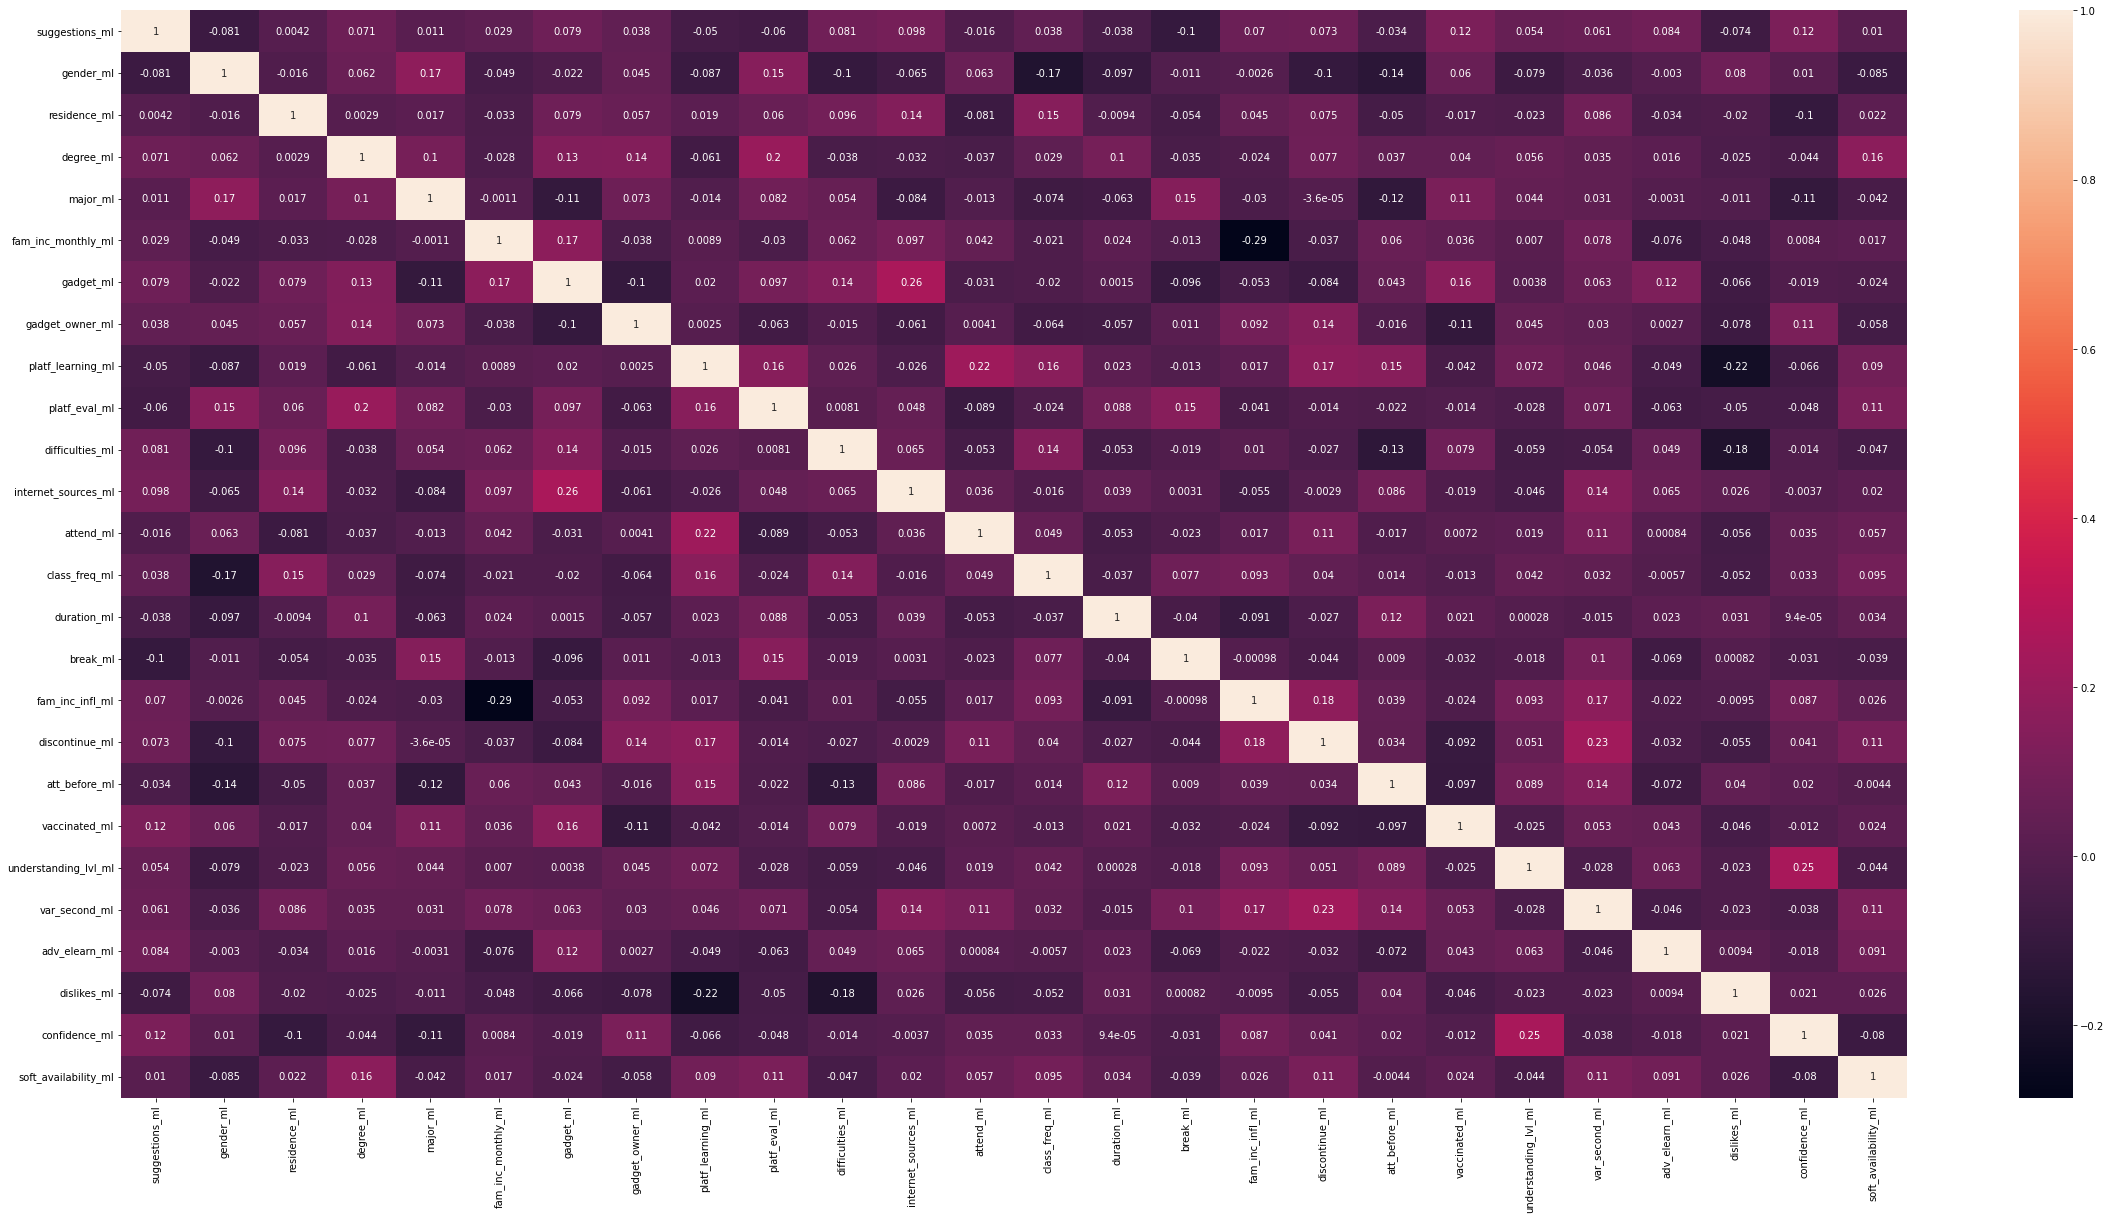

In [11]:
#correlation check:
corr_a = data_ml.corr()
plt.figure(figsize=[40, 20])
sns.heatmap(corr_a, annot=True)
plt.show()
# there is no single factor with strong influence or correlation.

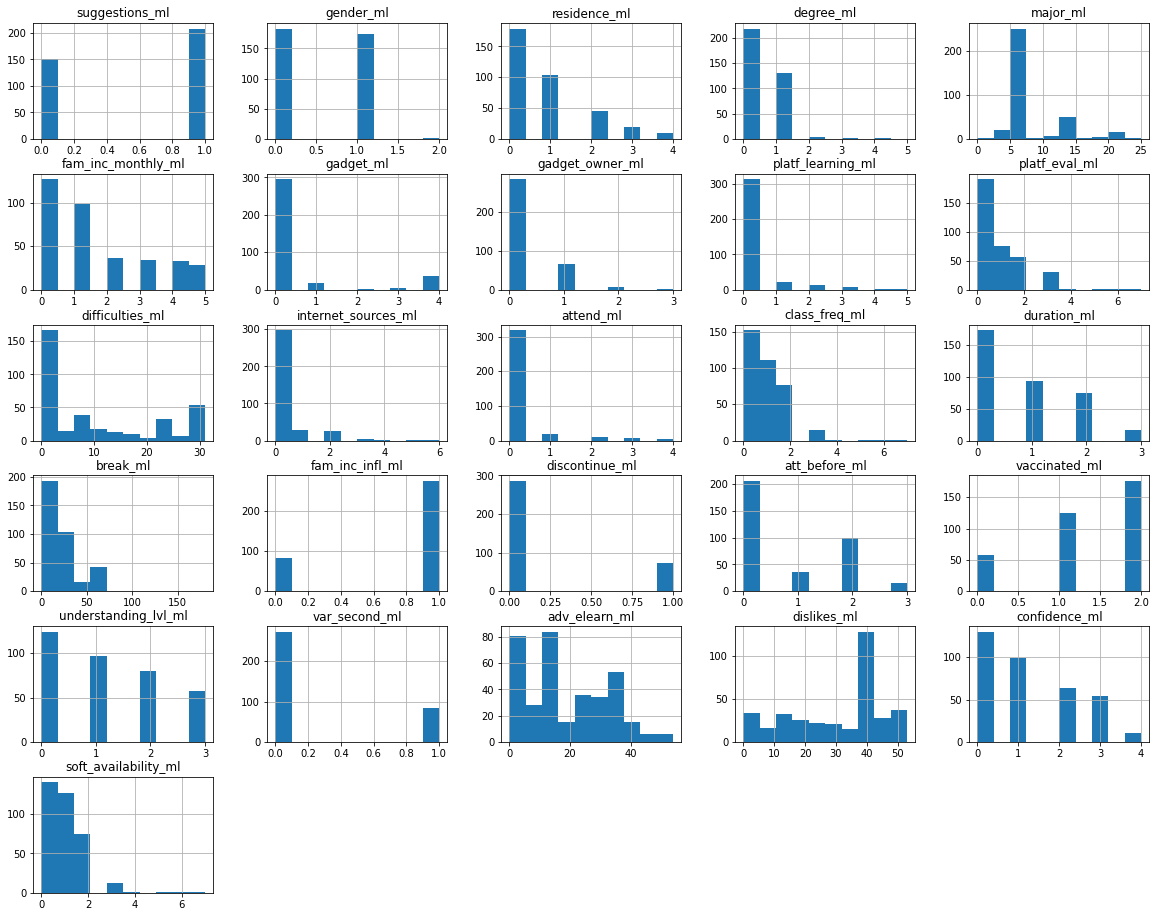

In [12]:
#histogram to check data distribution:

data_ml.hist(figsize=[20, 16])
plt.show()

In [13]:
# as can be seen, the data is extremely uneven -> measures to balance

# The process:

* Selecting a number of classification models for testing on MOOC data
* Rebalancing data with SMOTE and oversampling. Undersampling cannot be performed due to the small dataset size (358 entries in total)
* Implementing feature selection
* Choosing the final model

In [14]:
scaler = StandardScaler()

params = data_ml.drop(columns=['suggestions_ml'])
y = data_ml['suggestions_ml']
X = scaler.fit_transform(params)

#splits
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size = 0.2, random_state=1, stratify=data_ml.suggestions_ml)

Some models under primary consideration:
* KNN
* K-Means
* Logistic Regression
* Decision Tree Classifier
* Random Forest
* SVG

In [15]:
#KNN Classifier

knn = KNeighborsClassifier(n_neighbors=7, weights='distance')

knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

print(metrics.accuracy_score(y_test, y_pred_knn))
print(metrics.precision_score(y_test, y_pred_knn))
print(metrics.recall_score(y_test, y_pred_knn))
print(metrics.f1_score(y_test, y_pred_knn))
print(metrics.confusion_matrix(y_test, y_pred_knn))

rmse = sqrt(mean_squared_error(y_test, y_pred_knn))
print(rmse)
print(metrics.roc_auc_score(y_test, y_pred_knn))

0.6111111111111112
0.6666666666666666
0.6666666666666666
0.6666666666666666
[[16 14]
 [14 28]]
0.6236095644623235
0.6


In [16]:
#K-Means

kmn = KMeans(n_clusters = 2, random_state = 1, init='k-means++')

kmn.fit(X_train)
y_pred_kmn = kmn.predict(X_test)

print(metrics.accuracy_score(y_test, y_pred_kmn))
print(metrics.precision_score(y_test, y_pred_kmn))
print(metrics.recall_score(y_test, y_pred_kmn))
print(metrics.f1_score(y_test, y_pred_kmn))
print(metrics.confusion_matrix(y_test, y_pred_kmn))

rmse = sqrt(mean_squared_error(y_test, y_pred_kmn))
print(rmse)
print(metrics.roc_auc_score(y_test, y_pred_kmn))

0.5555555555555556
0.5862068965517241
0.8095238095238095
0.68
[[ 6 24]
 [ 8 34]]
0.6666666666666666
0.5047619047619047


In [17]:
#logistic regression

logr = LogisticRegression(penalty='l2', solver='liblinear', max_iter=100)
logr.fit(X_train, y_train)
y_pred_logr = logr.predict(X_test)

print(metrics.accuracy_score(y_test, y_pred_logr))
print(metrics.precision_score(y_test, y_pred_logr))
print(metrics.recall_score(y_test, y_pred_logr))
print(metrics.f1_score(y_test, y_pred_logr))
print(metrics.confusion_matrix(y_test, y_pred_logr))

print(logr.score(X_train, y_train))
print(logr.score(X_test, y_test))

rmse = sqrt(mean_squared_error(y_test, y_pred_logr))
print(rmse)
print(metrics.roc_auc_score(y_test, y_pred_logr))

0.5138888888888888
0.574468085106383
0.6428571428571429
0.6067415730337079
[[10 20]
 [15 27]]
0.6573426573426573
0.5138888888888888
0.6972166887783963
0.48809523809523814


In [18]:
# decision tree

dt = DecisionTreeClassifier(random_state=1, max_depth = 5)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
dt.score(X_test, y_test)

print(metrics.accuracy_score(y_test, y_pred_dt))
print(metrics.precision_score(y_test, y_pred_dt))
print(metrics.recall_score(y_test, y_pred_dt))
print(metrics.f1_score(y_test, y_pred_dt))
print(metrics.confusion_matrix(y_test, y_pred_dt))

rmse = sqrt(mean_squared_error(y_test, y_pred_dt))
print(rmse)
print(metrics.roc_auc_score(y_test, y_pred_dt))

0.5972222222222222
0.6326530612244898
0.7380952380952381
0.6813186813186813
[[12 18]
 [11 31]]
0.6346477588219923
0.5690476190476191


In [19]:
# random forest

rft = RandomForestClassifier(max_depth=8, n_estimators=100)
rft.fit(X_train, y_train)
y_pred_rft = rft.predict(X_test)
rft.score(X_test, y_test)

print(metrics.accuracy_score(y_test, y_pred_rft))
print(metrics.precision_score(y_test, y_pred_rft))
print(metrics.recall_score(y_test, y_pred_rft))
print(metrics.f1_score(y_test, y_pred_rft))
print(metrics.confusion_matrix(y_test, y_pred_rft))

rmse = sqrt(mean_squared_error(y_test, y_pred_rft))
print(rmse)
print(metrics.roc_auc_score(y_test, y_pred_rft))
#!!!Precision!!!

0.5833333333333334
0.6153846153846154
0.7619047619047619
0.6808510638297872
[[10 20]
 [10 32]]
0.6454972243679028
0.5476190476190477


In [20]:
# SVC

svc = SVC(kernel='rbf', C=100, class_weight='balanced', random_state=1)
svc.fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred_svc))
print(metrics.precision_score(y_test, y_pred_svc))
print(metrics.recall_score(y_test, y_pred_svc))
print(metrics.f1_score(y_test, y_pred_svc))
print(metrics.confusion_matrix(y_test, y_pred_svc))

rmse = sqrt(mean_squared_error(y_test, y_pred_svc))
print(rmse)
print(metrics.roc_auc_score(y_test, y_pred_svc))

0.6666666666666666
0.725
0.6904761904761905
0.7073170731707318
[[19 11]
 [13 29]]
0.5773502691896257
0.6619047619047619


So far, the most promising model is SVC, so let's implement resampling and oversampling to compare:

In [21]:
# SVC with resampling:
sm = SMOTE(random_state = 1, sampling_strategy='not majority', k_neighbors=9)
X_res, y_res = sm.fit_resample(X_train, y_train)

svc1 = SVC(kernel='rbf', C=100, class_weight='balanced', random_state=1)
svc1.fit(X_res, y_res)
y_pred_svc1 = svc1.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred_svc1))
print(metrics.precision_score(y_test, y_pred_svc1))
print(metrics.recall_score(y_test, y_pred_svc1))
print(metrics.f1_score(y_test, y_pred_svc1))
print(metrics.confusion_matrix(y_test, y_pred_svc1))

rmse1 = sqrt(mean_squared_error(y_test, y_pred_svc1))
print(rmse1)
print(metrics.roc_auc_score(y_test, y_pred_svc1))
print(metrics.log_loss(y_test, y_pred_svc1))

0.6944444444444444
0.7380952380952381
0.7380952380952381
0.7380952380952381
[[19 11]
 [11 31]]
0.5527707983925667
0.6857142857142857
10.553637170274543


In [22]:
# SVC with oversampling:
ovs = RandomOverSampler(random_state=1, sampling_strategy='minority')
X_ovs, y_ovs = ovs.fit_resample(X, y)
X_train_ovs, X_test_ovs, y_train_ovs, y_test_ovs = train_test_split(X_ovs, y_ovs, train_size = 0.8, test_size = 0.2, random_state=1)

svc2 = SVC(kernel='rbf', C=100, class_weight='balanced', random_state=1)
svc2.fit(X_train_ovs, y_train_ovs)
y_pred_svc2 = svc2.predict(X_test_ovs)
print(metrics.accuracy_score(y_test_ovs, y_pred_svc2))
print(metrics.precision_score(y_test_ovs, y_pred_svc2))
print(metrics.recall_score(y_test_ovs, y_pred_svc2))
print(metrics.f1_score(y_test_ovs, y_pred_svc2))
print(metrics.confusion_matrix(y_test_ovs, y_pred_svc2))

rmse_sovs = sqrt(mean_squared_error(y_test_ovs, y_pred_svc2))
print(rmse_sovs)
print(metrics.roc_auc_score(y_test_ovs, y_pred_svc2))
print(metrics.log_loss(y_test_ovs, y_pred_svc2))


#oversampling dropped the precision score while improving recall. It seems that the resampled model is more successful

0.6547619047619048
0.6
0.7692307692307693
0.6741573033707865
[[25 20]
 [ 9 30]]
0.5875696513930031
0.6623931623931625
11.924291754773973


In [23]:
# seqential feature selection:
sbs = SFS(svc1, k_features=7, forward=False, floating=True, scoring='accuracy', cv=0)
sbs.fit(X,y)
print(sbs.subsets_)

{25: {'feature_idx': (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24), 'cv_scores': array([1.]), 'avg_score': 1.0, 'feature_names': ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24')}, 24: {'feature_idx': (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23), 'cv_scores': array([1.]), 'avg_score': 1.0, 'feature_names': ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23')}, 23: {'feature_idx': (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22), 'cv_scores': array([1.]), 'avg_score': 1.0, 'feature_names': ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22')}, 22: {'feature_idx': (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17

In [24]:
data_ml.columns[[0, 1, 4, 8, 9, 12, 13, 17, 19, 21, 24]]

Index(['suggestions_ml', 'gender_ml', 'major_ml', 'platf_learning_ml',
       'platf_eval_ml', 'attend_ml', 'class_freq_ml', 'discontinue_ml',
       'vaccinated_ml', 'var_second_ml', 'confidence_ml'],
      dtype='object')

In [25]:
# the selected features
data_ml1 = data_ml[['gender_ml', 'degree_ml', 'major_ml', 'platf_learning_ml', 'platf_eval_ml', 'class_freq_ml', 'duration_ml']]

yn = data_ml['suggestions_ml']
Xn = scaler.fit_transform(data_ml1)

#splits
X_train1, X_test1, y_train1, y_test1 = train_test_split(Xn, yn, train_size = 0.8, test_size = 0.2, random_state=1, stratify=data_ml.suggestions_ml)

In [26]:
# new SVC with resampling:

X_resn, y_resn = sm.fit_resample(X_train1, y_train1)

svcn = SVC(kernel='rbf', C=100, class_weight='balanced', random_state=1)
svcn.fit(X_resn, y_resn)
y_pred_svcn = svcn.predict(X_test1)
print(metrics.accuracy_score(y_test1, y_pred_svcn))
print(metrics.precision_score(y_test1, y_pred_svcn))
print(metrics.recall_score(y_test1, y_pred_svcn))
print(metrics.f1_score(y_test1, y_pred_svcn))
print(metrics.confusion_matrix(y_test1, y_pred_svcn))

rmsen = sqrt(mean_squared_error(y_test1, y_pred_svcn))
print(rmsen)
print(metrics.roc_auc_score(y_test1, y_pred_svcn))
print(metrics.log_loss(y_test1, y_pred_svcn))

#It appears that decreasing the number of features is counter-productive for this model

0.5
0.5714285714285714
0.5714285714285714
0.5714285714285714
[[12 18]
 [18 24]]
0.7071067811865476
0.48571428571428565
17.26958809681289


# Summary conclusions:

Due to the small dataset size and the imbalanced nature of the data, it is unrealistic to expect a very high accuracy from the model. Here are the final metrics:

* Accuracy: 0.6944444444444444
* Precision: 0.7380952380952381
* Recall: 0.7380952380952381
* F1-score: 0.7380952380952381

Confusion matrix:
* TP: 19 
* FP: 11
* FN: 11
* TN: 31

* RMSE score: 0.5527707983925667
* Auroc score: 0.6857142857142857
* Log loss: 10.553637170274543

Considering all the other scores, this model might be useable in predicting student suggestions with a reasonable error margin.